# Hands-on Introduction to Explainable AI: Attribution Methods
## **Exercise 1**: _Interpreting a Used Car Price Predictor_
### Workshop for ML Conference Münich — scheduled for June 22nd, 2023 8:00 AM CET
### by Serg Masís ([LinkedIn](https://www.linkedin.com/in/smasis/), [Twitter](https://twitter.com/smasis), [Serg.ai](https://www.serg.ai/), [Github](https://github.com/smasis001), [Amazon](https://www.amazon.com/kindle-dbs/entity/author/B08PQ8P9BS?_encoding=UTF8&node=283155&offset=0&pageSize=12&searchAlias=stripbooks&sort=author-sidecar-rank&page=1&langFilter=default#formatSelectorHeader) )

**The Mission**

The used car market in the United States is a thriving and substantial industry with significant economic impact. In recent years, approximately 40 million used light vehicles have been sold yearly, representing over two-thirds of the overall automotive sector. In addition, the market has witnessed consistent growth, driven by the rising cost of new vehicles, longer-lasting cars, and an increasing consumer preference for pre-owned vehicles due to the perception of value for money. As a result, this market segment has become increasingly important for businesses and consumers.

Given the market opportunity, a tech startup is currently working on a machine-learning-driven, two-sided marketplace for used car sales. It plans to work much like the e-commerce site E-bay except it's focused on cars. You have been hired to understand which features are useful to the machine learning model and why, for all cars but also for their corporate sponsor "Ford". This is critical because the startup only wants to ask sellers to provide the bare minimum of details about their car before they get a price estimate. Of course, there are details like the car's make and model and even the color that another machine-learning model can automatically guess from the pictures. Still, some features like the transmission or cylinders may vary in the car model, and the seller may not know or be willing to disclose them. Limiting the questions asked produces the least friction and thus will lead to more sellers completing their listings successfully.

**The Solution**

This notebook will walk through:



- Preparing the data with categorical encoding
- Train many regressors for all car brands and many classifiers for "Ford" vehicles only
- Explore model-specific intepretations for some model classes
- Perform global explanations with the SHAP library
- Visualize feature summary explanations
- Connect the dots with feature interactions
- Understand individual predictions with local explanations

## 1) Install Libraries

Only if not Google Colab because google colab has these preinstalled:

In [ ]:
!pip install numpy==1.21.6 pandas==1.3.5 tqdm==4.64.0 scikit-learn==1.0.2 matplotlib==3.1.1 seaborn==0.11.2

Always installed unless installed already:

In [1]:
!pip install pdpbox catboost imodels interpret shap PyALE lime==0.2.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.5/195.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.0/758.0 kB

Wait for all packages to install. You might need to restart runtime after installing them. It also might throw a few minor errors but still install them successfully.

## 2) Load Libraries

In [2]:
import math
import os, random
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=DeprecationWarning)

#DATA WRANGLING
import numpy as np
import pandas as pd
#from folktables import ACSDataSource, ACSEmployment
from sklearn.model_selection import train_test_split

#MODELING
from tqdm.notebook import trange, tqdm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn import metrics, linear_model, tree, naive_bayes,\
                    neighbors, ensemble, neural_network
import catboost as cb
#from rulefit import RuleFit
from imodels import FIGSClassifier, FIGSRegressor
from interpret.glassbox import ExplainableBoostingClassifier, ExplainableBoostingRegressor

#VISUALIZATION & INTERPRETATION
import matplotlib.pyplot as plt
import seaborn as sns
from interpret import show
from pdpbox import pdp, info_plots
from PyALE import ale
from lime.lime_tabular import LimeTabularExplainer
import shap

## 3) Data Understanding & Preparations

### 3.1) Load Dataset

In [3]:
url = "https://github.com/smasis001/mlconf-2023/blob/main/data/usedcars-3e.csv?raw=true"
usedcars_df = pd.read_csv(url)
usedcars_df.set_index('id', inplace=True)

usedcars_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256065 entries, 7316814884 to 7302338378
Data columns (total 27 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   price                            256065 non-null  int64  
 1   region                           256065 non-null  object 
 2   posting_date                     256065 non-null  object 
 3   lat                              256065 non-null  float64
 4   long                             256065 non-null  float64
 5   zip                              256065 non-null  int64  
 6   make                             256065 non-null  object 
 7   make_cat                         256065 non-null  object 
 8   make_pop                         256065 non-null  float64
 9   model                            256065 non-null  object 
 10  model_premier                    256065 non-null  int64  
 11  year                             256065 non-null  in

The data dictionary for the the dataset is as follows:


- variables related to the listing:
    - `price`: target, continuous, the price posted for the vehicle
    - `region`: categorical, the region for the listing — usually this is a city, metropolitan area, or for more rural areas a portion of a state or a least populated state  (out of 402).
    - `posting_date`: datetime, the date and time of the posting (all postings are for the a single month period in 2021 so you cannot observe season patterns with it)
    - `lat`: continuous, the latitude in decimal format
    - `long`: continuous, the longitude in decimal format
    - `zip`: nominal, the zip code (out of over 13,100)
    
- variables related to the vehicle:
    - `make`: categorical, the brand or manufacturer of the vehicle  (out of 37)
    - `make_cat`:  categorical, the category for the make (out of 5). It's `obsolete` for makes no longer produced such as "Saturn", `luxury sports` for brands like "Ferrari", and `luxury` for brands like "Mercedes-Benz". Everything else is `regular` or `premium`. The only difference is `premium` include brands like "Cadillac" and "Acura" which are the high-end brands of car manufacturers in the `regular` category.
    - `make_pop`: continuous, the relative popularity of the make in percentiles (0-1)
    - `model`: categorical, the model (out of over 17,000)
    - `model_premier`: binary, whether the model is a luxury version/trim of a model (if the model itself is not already high-end such as those in the luxury, luxury sports or premium categories)
    - `year`: ordinal, the year of the model (from 1984-2022)
    - `make_yr_pop`: continuous, the relative popularity of the make for the year it was made for in percentiles (0-1)
    - `model_yr_pop`: continuous, the relative popularity of the model for the year it was made forin percentiles (0-1)
    - `odometer`: continuous, the reading in the vehicle's odometer
    - `auto_trans`: binary, whether the car has automatic transmission - otherwise it is manual
    - `fuel`: categorical, the type of fuel used (out of 5: `gas`, `diesel`, `hybrid`, `electric` and `other`)
    - `model_type`:categorical,  (out of 13: `sedan`, `SUV`, and `pickup` are the three most popular, by far)
    - `drive`: categorical, whether it's four-wheel, front-wheel or rear-wheel drive (out of 3: `4wd`, `fwd` and `rwd`)
    - `cylinders`: nominal, the number of cylinders of the engine (from 2- 16). Generally, the more cylinders, the higher the horsepower
    - `title_status`: categorical, what the title says about the status of the vehicle (out of 7 like `clean`, `rebuilt`, `unknown`, `salvage` and `lien`)
    - `condition`: categorical, what the owner reported the condition of the vehicle to be (out of 7 like `good`, `unknown`, `excellent` and `like new`)
    
- variables related to the emissions of the vehicle:
    - `epa_co2`: continuous, tailpipe CO2 in grams/mile. For models after 2013, it is based on EPA tests. For previous years, CO2 is estimated using an EPA emission factor (-1 = Not Available)
    - `epa_displ`: continuous , the engine displacement (in liters from 0.6 - 8.4)
    
- variables related to the zip code of the listing:
    - `zip_population`: continuous, the population
    - `zip_density`: continuous, the density(residents per sq. mile)
    - `est_households_medianincome_usd`: continuous, the median household income

### 3.2) Preprocess Steps

There are a few quick preprocessing steps we will need to do since we need to encode all categorical variables as numbers and also would like to set aside one dataframe with just Ford vehicles.

Before doing some data preparation, let's backup the original dataframe:

In [4]:
usedcars_orig_df = usedcars_df.copy()

#### 3.2.1) One Hot Encoding

The first thing we will do is One Hot Encode the categorical variables:

In [5]:
cat_cols_l = ["fuel", "make_cat", "model_type", "condition", "drive", "title_status"]

We can OHE them with the following code:

In [6]:
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

ohe_arr = ohe.fit_transform(usedcars_df[cat_cols_l])
ohe_cols_l = ohe.get_feature_names_out(cat_cols_l)
usedcars_df[ohe_cols_l] = ohe_arr

usedcars_df = usedcars_df.drop(cat_cols_l, axis=1)

The above snippet got rid of many `object` columns by turning them into a series of binary columns (of the `uint8` type). You can check what happened with this code:

In [7]:
usedcars_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256065 entries, 7316814884 to 7302338378
Data columns (total 58 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   price                            256065 non-null  int64  
 1   region                           256065 non-null  object 
 2   posting_date                     256065 non-null  object 
 3   lat                              256065 non-null  float64
 4   long                             256065 non-null  float64
 5   zip                              256065 non-null  int64  
 6   make                             256065 non-null  object 
 7   make_pop                         256065 non-null  float64
 8   model                            256065 non-null  object 
 9   model_premier                    256065 non-null  int64  
 10  year                             256065 non-null  int64  
 11  make_yr_pop                      256065 non-null  fl

#### 3.2.2) Make Ford-only dataframe

Before, we go further, let's set aside a dataframe with only Ford vehicles we will use for a classifier:

In [8]:
usedcars_ford_df = usedcars_df[usedcars_df["make"] == "ford"]

#### 3.2.3) Remove remaining "object" columns

However, there are still a few `object` columns left in both `usedcars_df` and `usedcars_ford_df`. We can find out which ones like this:

In [9]:
usedcars_df.dtypes[lambda x: x == object].index.tolist()

['region', 'posting_date', 'make', 'model']

We don't need any of these columns since we have `latitude`, `longitude`, and some of the demographic features, which provide the model some idea of where the car was being sold. As for the `make` and `model`, we have the `make` and `model` popularity and category features. We can remove the non-numerical features by simply only selecting the numerical ones like this.

In [10]:
usedcars_df = usedcars_df.select_dtypes(include=(int,float,np.uint8))
usedcars_ford_df = usedcars_ford_df.select_dtypes(include=(int,float,np.uint8))

#### 3.2.4) Drop constant columns

The problem with selecting a single `make` with the `usedcars_ford_df` dataframe is that it left several constant columns:

In [11]:
constant_cols_l = usedcars_ford_df.columns[usedcars_ford_df.nunique() <= 1]
print(constant_cols_l)

Index(['make_pop', 'make_cat_luxury', 'make_cat_luxury sports',
       'make_cat_obsolete', 'make_cat_premium', 'make_cat_regular'],
      dtype='object')


We can get rid of them like this:

In [12]:
usedcars_ford_df = usedcars_ford_df.drop(constant_cols_l, axis=1)

### 3.2.5) Set Seed For Reproducibility

Define a seed for reproducibility:

In [13]:
rand = 42
os.environ['PYTHONHASHSEED']=str(rand)
np.random.seed(rand)
random.seed(rand)

Define `X` and `y` and then test/train split them, as well as make lists for our classes (`class_l`) and features (`feature_cls_l`).

### 3.2.6) Train/Test split for regression model

In [14]:
target_col = 'price'

usedcars_sample_df = usedcars_df.sample(frac=0.25, random_state=rand)

X_reg = usedcars_sample_df.drop([target_col], axis=1)
y_reg = usedcars_sample_df[target_col].values
feature_reg_l = X_reg.columns.tolist()

X_reg_train, X_reg_test, y_reg_train, y_reg_test =\
        train_test_split(X_reg, y_reg, test_size=0.25, random_state=rand)

### 3.2.7) Train/Test split for classification model

In [15]:
price_threhold = usedcars_ford_df[target_col].quantile(0.75)
print(f"${price_threhold:,}")

$28,500.0


In [16]:
class_l = ['Low Price','High Price']

X_cls = usedcars_ford_df.drop([target_col], axis=1)
y_cls = np.where(usedcars_ford_df[target_col] < price_threhold, 0, 1)
feature_cls_l = X_cls.columns.tolist()

X_cls_train, X_cls_test, y_cls_train, y_cls_test =\
        train_test_split(X_cls, y_cls, test_size=0.25, random_state=rand)

## 4) Modeling & Evaluation

### 4.1) Define Models to train

We will quickly train 9 regression...

In [17]:
reg_models = {
        #Generalized Linear Models (GLMs)
        'lr':{'model': make_pipeline(StandardScaler(),
                                           linear_model.LinearRegression(n_jobs=-1))},
        'lasso':{'model': make_pipeline(StandardScaler(),
                                           linear_model.LassoCV(alphas=np.linspace(0, 2, 31), n_jobs=-1,\
                                                                cv=5, random_state=rand))},
        'ridge':{'model': make_pipeline(StandardScaler(),
                                           linear_model.RidgeCV(alphas=np.linspace(25, 30, 16), cv=5,\
                                                                scoring="neg_median_absolute_error"))},

        #Nearest Neighbors
        'knn':{'model': neighbors.KNeighborsRegressor(n_neighbors=5, algorithm='kd_tree', n_jobs=-1)},

        #Tree
        'decision_tree':{'model': tree.DecisionTreeRegressor(max_depth=5, random_state=rand)},


        #Interpretable rule-based models
        'figs':{'model': FIGSRegressor(max_rules=20, random_state=rand),\
                'fit_args':{'feature_names':feature_reg_l}},

        #Ensemble Methods
        'random_forest':{'model':ensemble.RandomForestRegressor(max_depth=7, random_state=rand)},
        'catboost':{'model': cb.CatBoostRegressor(max_depth=5, random_state=rand, verbose=0)},

        #Neural Networks
        'mlp':{'model':make_pipeline(MinMaxScaler(),\
                                     neural_network.MLPRegressor(hidden_layer_sizes=(20,), max_iter=400,\
                                                   early_stopping=True, random_state=rand))}
    }

...and 9 classification models.

In [18]:
cls_models = {
        #Generalized Linear Models (GLMs)
        'logistic':{'model': make_pipeline(StandardScaler(),
                                           linear_model.LogisticRegression(C=10,  penalty='l1', solver='liblinear',\
                                                                           random_state=rand, class_weight='balanced'))},

        #Naive Bayes
        'naive_bayes':{'model': naive_bayes.GaussianNB()},

        #Nearest Neighbors
        'knn':{'model': neighbors.KNeighborsClassifier(n_neighbors=7, algorithm='kd_tree', n_jobs=-1)},

        #Tree
        'decision_tree':{'model': tree.DecisionTreeClassifier(max_depth=3, class_weight='balanced',\
                                                              random_state=rand)},


        #Interpretable rule-based models
        'figs':{'model': FIGSClassifier(max_rules=10, random_state=rand),\
                'fit_args':{'feature_names':feature_cls_l}},

        #Interpretable GAM-based models
        'ebm':{'model': ExplainableBoostingClassifier(random_state=rand, learning_rate=0.03, n_jobs=-1,\
                                                      feature_names=feature_cls_l)},

        #Ensemble Methods
        'random_forest':{'model':ensemble.RandomForestClassifier(max_depth=5, class_weight='balanced',\
                                                                 random_state=rand)},
        'catboost':{'model': cb.CatBoostClassifier(max_depth=3, scale_pos_weight=1.3, random_state=rand,\
                                                   verbose=0)},

        #Neural Networks
        'mlp':{'model':make_pipeline(MinMaxScaler(),\
                                     neural_network.MLPClassifier(hidden_layer_sizes=(8,), max_iter=500,\
                                                   early_stopping=True, random_state=rand))}
    }

A couple of disclaimers:

- No hyperparameter tuning since I've already predetermined some good hyperparameters.
- It's highly recommended to evaluate on Stratified K-Fold cross-validation but we won't have time to do that now. In any case, the results won't be too far from the CV averages.

### 4.2) Batch train and evaluate

It should take 1-4 minutes to iterate across all models `fit`, `predict` and `score` all regression models:

In [19]:
%%time
for model_name in tqdm(reg_models.keys()):
    fitted_model = reg_models[model_name]['model']
    if 'fit_args' in reg_models[model_name]:
        fitted_model.fit(X_reg_train.values, y_reg_train,\
                         **reg_models[model_name]['fit_args'])
        y_reg_train_pred = fitted_model.predict(X_reg_train.values)
        y_reg_test_pred = fitted_model.predict(X_reg_test.values)
    else:
        fitted_model.fit(X_reg_train, y_reg_train)
        y_reg_train_pred = fitted_model.predict(X_reg_train)
        y_reg_test_pred = fitted_model.predict(X_reg_test)
    reg_models[model_name]['pred_test'] = y_reg_test_pred
    reg_models[model_name]['rmse_train'] = metrics.mean_squared_error(y_reg_train, y_reg_train_pred,\
                                                                      squared=False)
    reg_models[model_name]['rmse_test'] = metrics.mean_squared_error(y_reg_test, y_reg_test_pred,\
                                                                     squared=False)
    reg_models[model_name]['mae'] = metrics.mean_absolute_error(y_reg_test, y_reg_test_pred)
    reg_models[model_name]['mdae'] = metrics.median_absolute_error(y_reg_test, y_reg_test_pred)
    reg_models[model_name]['maxerr'] = metrics.max_error(y_reg_test, y_reg_test_pred)
    reg_models[model_name]['r2'] = metrics.r2_score(y_reg_test, y_reg_test_pred)

  0%|          | 0/9 [00:00<?, ?it/s]

CPU times: user 2min 44s, sys: 37.4 s, total: 3min 21s
Wall time: 3min 38s


It should also take 1-5 minutes to iterate across all models `fit`, `predict` and `score` all classification models:

In [20]:
%%time
for model_name in tqdm(cls_models.keys()):
    fitted_model = cls_models[model_name]['model']
    if 'fit_args' in cls_models[model_name]:
        fitted_model.fit(X_cls_train.values, y_cls_train,\
                         **cls_models[model_name]['fit_args'])
        y_cls_train_pred = fitted_model.predict(X_cls_train.values)
        y_cls_test_prob = fitted_model.predict_proba(X_cls_test.values)[:,1]
    else:
        fitted_model.fit(X_cls_train, y_cls_train)
        y_cls_train_pred = fitted_model.predict(X_cls_train)
        y_cls_test_prob = fitted_model.predict_proba(X_cls_test)[:,1]
    y_cls_test_pred = np.where(y_cls_test_prob > 0.5, 1, 0)
    cls_models[model_name]['pred_test'] = y_cls_test_pred
    cls_models[model_name]['prob_test'] = y_cls_test_prob
    cls_models[model_name]['acc_train'] = metrics.accuracy_score(y_cls_train, y_cls_train_pred)
    cls_models[model_name]['acc_test'] = metrics.accuracy_score(y_cls_test, y_cls_test_pred)
    cls_models[model_name]['precision'] = metrics.precision_score(y_cls_test, y_cls_test_pred)
    cls_models[model_name]['recall'] = metrics.recall_score(y_cls_test, y_cls_test_pred)
    cls_models[model_name]['f1'] = metrics.f1_score(y_cls_test, y_cls_test_pred)
    cls_models[model_name]['roc-auc'] = metrics.roc_auc_score(y_cls_test, y_cls_test_prob)
    cls_models[model_name]['mcc'] = metrics.matthews_corrcoef(y_cls_test, y_cls_test_pred)

  0%|          | 0/9 [00:00<?, ?it/s]

CPU times: user 39.6 s, sys: 5.79 s, total: 45.4 s
Wall time: 4min


### 4.3) Compare models
#### _Model selection_?

The following code simply takes the dictionary produced in the previous step and converts it into a dataframe. It also formats it to have the top 4 models for every metric color-coded.


First, the regression models.

In [22]:
def set_header_font():
    return [dict(selector="th", props=[("font-size", "14pt")])]

reg_metrics_df = pd.DataFrame.from_dict(reg_models, 'index').drop(['model','fit_args','pred_test'], axis=1)
reg_metrics_df.sort_values(by='mdae', ascending=True).style.\
    format(dict(zip(reg_metrics_df.columns, ['{:,.0f}']*5 + ['{:.3f}']))).\
    set_properties(**{'font-size': '13pt'}).set_table_styles(set_header_font()).\
    background_gradient(cmap='plasma_r', low=0.3, high=0.1, subset=['rmse_train','rmse_test']).\
    background_gradient(cmap='viridis_r', low=0.3, high=0.1, subset=['mae','mdae','maxerr']).\
    background_gradient(cmap='viridis', low=0.1, high=0.3, subset=['r2']).\
    highlight_quantile(q_left=0.6, q_right=1, subset=['rmse_train','rmse_test','mae','mdae','maxerr'], props='color:black; background-color:inherit').\
    highlight_quantile(q_left=0, q_right=0.6, subset=['r2'], props='color:black; background-color:inherit').\
    highlight_min(props='font-weight:bold;', subset=['rmse_train','rmse_test','mae','mdae','maxerr']).\
    highlight_max(props='font-weight:bold;', subset=['r2'])

and now the classification models:

In [23]:
cls_metrics_df = pd.DataFrame.from_dict(cls_models, 'index').drop(['model','fit_args','pred_test','prob_test'], axis=1)
cls_metrics_df = cls_metrics_df*100
cls_metrics_df.sort_values(by='f1', ascending=False).style.\
    format(dict(zip(cls_metrics_df.columns, ['{:.1f}']*7))).\
    set_properties(**{'font-size': '13pt'}).set_table_styles(set_header_font()).\
    background_gradient(cmap='plasma', low=0.3, high=0.1, subset=['acc_train', 'acc_test']).\
    background_gradient(cmap='viridis', low=0.3, high=0.1, subset=['precision','recall',\
                                                                 'f1', 'mcc']).\
    highlight_quantile(q_left=0, q_right=0.6, props='color:black; background-color:inherit').\
    highlight_max(props='font-weight:bold;')

Usually this is the extent of all model "interpretation" performed. Solely for model-selection purposes which is like piloting an old-fashioned plane with half a dozen instruments. Indeed, Interpretable ML (or XAI) is like the collection of tools used to "pilot" AI/ML. And it's advisable to do a lot more that comparing metrics.

![AI Right Now](https://github.com/smasis001/av-2022/blob/main/AI-Right-Now.png?raw=1)

Which plane would you rather pilot (or be a passenger in)? Be honest! Left or right?

Just as additional instrumentation in planes makes flying safer, additional instrumentation in ML can make predictive modelling fairer, more robust, and overall, more trustworthy.

But starting to understand a model starts with the foundation:

![FAT Diagram](https://github.com/smasis001/av-2022/blob/main/FAT_diagram2v2_LI.gif?raw=1)

As you can appreciate in the diagram, transparency is at the bottom so we need to understand the models first and foremost. So, let's...

> # DIG DEEPER!

## 5) Model explanations/interpretations

This section is about learning how the model works or at least an interpretation of how it's arriving to it's predictions.

When looking under the hood some models are priviledged with simple mechanisms. These are typically referred to as **White Box**. On the other hand, **Black Box** models are too complex to make sense us. For the former we can use **model-specific methods** and for the latter mostly **model-agnostic methods** are used.

![White Box, Black Box](https://github.com/smasis001/av-2022/blob/main/WhiteBoxBlackBox.png?raw=1)

### 5.1) Model-specific (using intrinsic parameters)

#### 5.1.1) Linear / Lasso / Ridge Regression

Linear regression, like all Generalized Linear Models (GLM), has a mathematical formula:

$\large{\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \text{...}}$

The formula is the same for Lasso and Ridge but the fitting is penalized.

The $\beta$'s are the coefficients (the $\beta_0$ being the intercept). If you wanted to, you could reconstruct the formula from a model. You can start by extracting the coefficients and intercept like this.

In [24]:
coefs_lr = reg_models['lr']['model'].steps[1][1].coef_
intercept_lr = reg_models['lr']['model'].steps[1][1].intercept_
print('coefficients:\t%s' % coefs_lr)
print('intercept:\t%s' % intercept_lr)

coefficients:	[ 7.37612852e+01 -1.16903594e+03 -3.76171023e+02  3.05411866e+02
  2.15652974e+03  7.15241673e+03  2.69318665e+02 -3.23465296e+02
 -1.43484897e+03 -5.75089327e+02  1.33351850e+03  9.69640285e+02
  1.59523261e+03 -3.88236510e+01 -1.18038973e+02  3.08727416e+01
  5.48139773e+14  1.21851633e+14  7.23142275e+14  3.06773232e+14
  3.80421058e+14  5.22904066e+13  2.13037838e+13  2.11533949e+13
  5.51890310e+13  7.66609722e+13 -3.52670900e+14 -4.12579142e+13
 -9.06989890e+13 -8.96364398e+13 -1.21024945e+14 -1.00281906e+14
 -2.93826100e+14 -3.58268157e+14 -7.24310280e+13 -7.78807595e+13
 -9.10089964e+13 -5.22174322e+14 -1.40795144e+14 -5.74848369e+14
 -2.71630876e+14 -6.10591263e+13 -4.02736736e+13 -5.75807672e+14
 -1.06529829e+15 -9.92296181e+14 -7.21348842e+14  1.38667324e+15
  3.95636351e+14  1.24295303e+14  8.95556086e+14  6.22744746e+14
  7.93564347e+14]
intercept:	18045.220321899797


The rest is simply some simple math such as a dot product.

In any case, although it's helpful to understand the math, it's more important to understand what matters most to the model. Fortunately since the features had already been standarized in the `sklearn` pipeline, the coefficients already tell this story. All we have to do is take their absolute value and rank them. And voilá! We have the feature importance for the linear regression model.

In [25]:
pd.DataFrame({'feature':feature_reg_l, 'coef':np.abs(coefs_lr)}).sort_values('coef', ascending=False).head(20).style.\
            set_properties(**{'font-size': '12pt'}).set_table_styles(set_header_font())

#### 5.1.2) Logistic Regression

Logistic regression, also has a mathematical formula:

$P(\hat{y}^{(i)}=1) = \huge{\frac{e^{\beta_0 + \beta_1 X_1^{(i)} + \beta_2 X_2^{(i)} \text{...}  + \beta_n X_n^{(i)}}}{1 + e^{\beta_0 + \beta_1 X_1^{(i)} + \beta_2 X_2^{(i)} \text{...}  + \beta_n X_n^{(i)}}}}$

You could also reconstruct the formula from a model, using these coefficients and intercept:

In [26]:
coefs_log = cls_models['logistic']['model'].steps[1][1].coef_[0]
intercept_log = cls_models['logistic']['model'].steps[1][1].intercept_
print('coefficients:\t%s' % coefs_log)
print('intercept:\t%s' % intercept_log)

coefficients:	[-0.03293595 -0.09338486  0.17922462  0.2717798   2.96040082  0.01102253
  0.17147561 -1.82019725 -0.47450206  0.6576385   0.10877093  0.10264342
 -0.09489871 -0.02458252  0.09174496  0.43457012 -0.11442689 -0.49453528
 -0.24801592 -0.02674159 -0.68237574  0.00717341  0.12387382 -0.92353753
 -0.00593644  0.06557428  0.08343802 -0.35261784  0.12661616 -0.00979411
 -0.20230202 -0.17447263 -0.78433288 -0.23737043 -0.0393059   0.13331045
 -0.20489669 -0.05117309  0.2452499  -0.94099539 -0.1115449   0.17475936
  0.02592929 -0.08016368 -0.19398354 -0.06125963 -0.00546127]
intercept:	[-2.49636917]


You then do the dot product and the plug it into the fomula.

We can do the same for logistic regression we did for linear regression.

In [27]:
pd.DataFrame({'feature':feature_cls_l, 'coef':np.abs(coefs_log)}).sort_values('coef', ascending=False).head(20).style.\
            set_properties(**{'font-size': '12pt'}).set_table_styles(set_header_font())

Another model that has coefficients that can be understood as part of a mathematical formula is **Naive Bayes**.

On the other hand, **K-Nearest Neighbors** can't be understood as a mathematical formula because all it is training data which when predicting uses the `k` closest points in the training data to make predictions. This can be easily understood on a instance by instance basis by retrieving the closest points.

#### 5.1.3) Decision Tree

Decision tree is one of the most intuitive models to understand. Our classification model only has a depth of three too which makes it even easier:

In [28]:
text_tree = tree.export_text(cls_models['decision_tree']['model'],\
               feature_names=feature_cls_l)
print(text_tree)

|--- year <= 2014.50
|   |--- fuel_gas <= 0.50
|   |   |--- year <= 2010.50
|   |   |   |--- class: 0
|   |   |--- year >  2010.50
|   |   |   |--- class: 1
|   |--- fuel_gas >  0.50
|   |   |--- odometer <= 51687.00
|   |   |   |--- class: 0
|   |   |--- odometer >  51687.00
|   |   |   |--- class: 0
|--- year >  2014.50
|   |--- drive_fwd <= 0.50
|   |   |--- model_type_SUV <= 0.50
|   |   |   |--- class: 1
|   |   |--- model_type_SUV >  0.50
|   |   |   |--- class: 1
|   |--- drive_fwd >  0.50
|   |   |--- year <= 2018.50
|   |   |   |--- class: 0
|   |   |--- year >  2018.50
|   |   |   |--- class: 1



As you can see, `year` is a super prominent feature and there are only eight leaves.

We can plot a graph with the tree too with even more details:

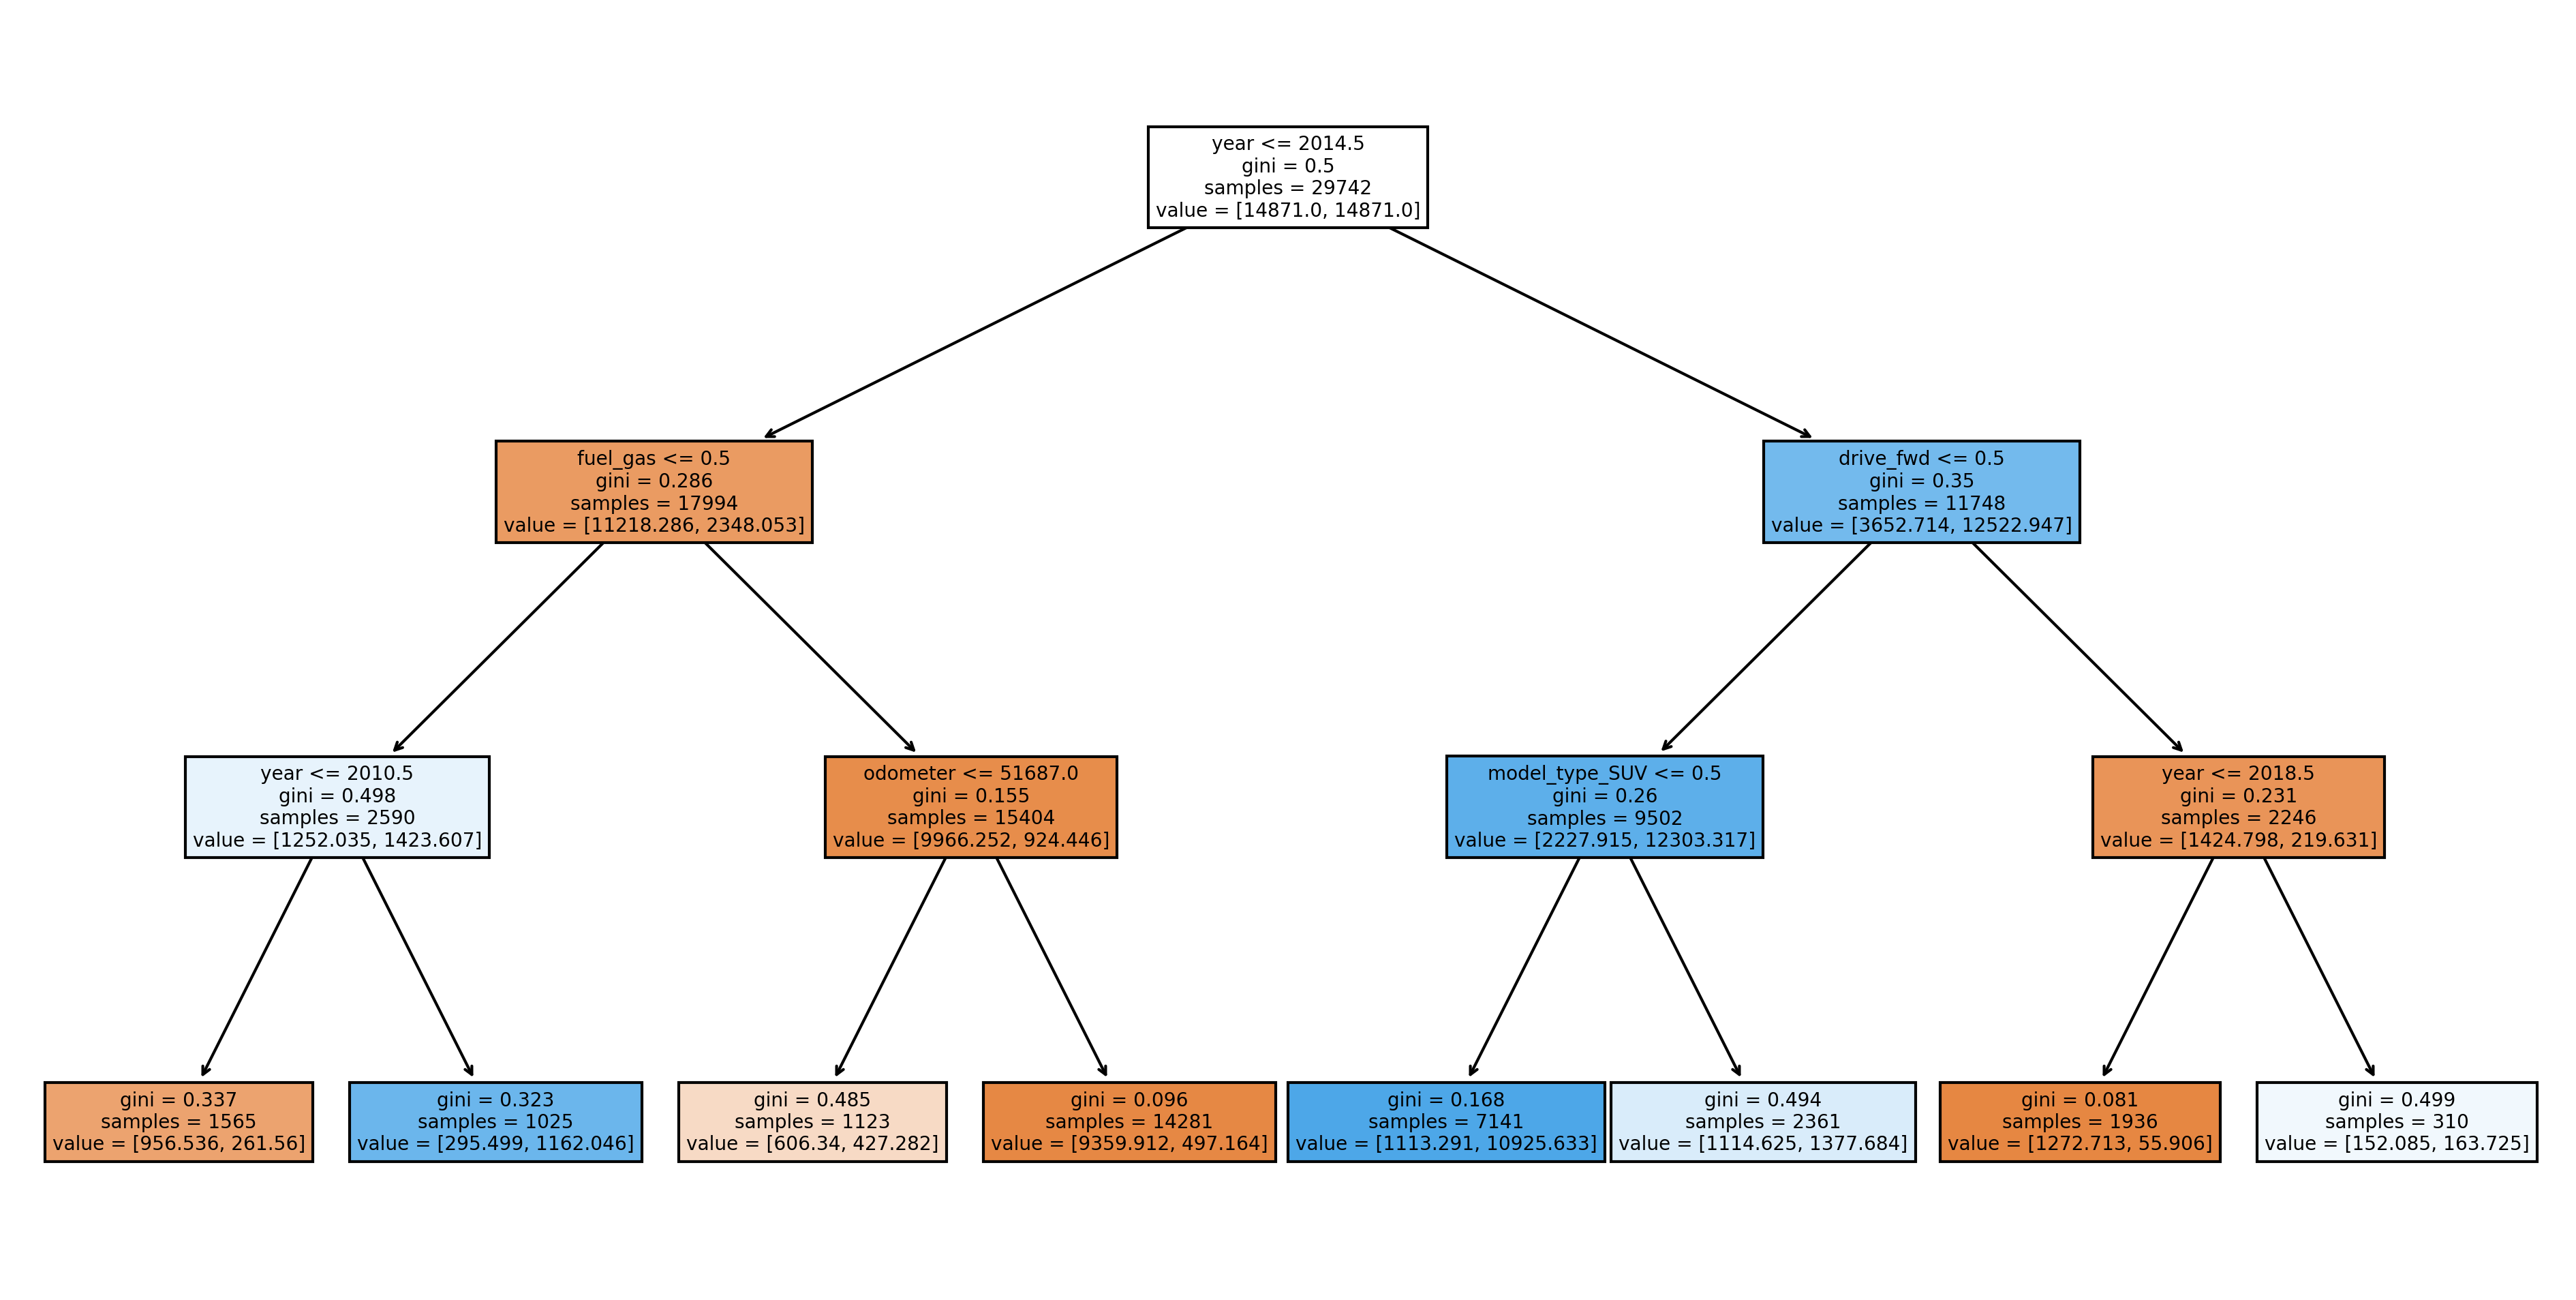

In [29]:
%matplotlib inline
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (16,8), dpi=300)
tree.plot_tree(cls_models['decision_tree']['model'], feature_names=feature_cls_l,\
               filled=True, max_depth=3)
fig.show()

As you can see, each node has a **gini coefficient**. It can use this to tally the importances of each feature:

In [30]:
dt_imp_df = pd.DataFrame({'feature':feature_cls_l,\
                        'importance': cls_models['decision_tree']['model'].feature_importances_})
dt_imp_df[dt_imp_df.importance > 0].sort_values(by='importance', ascending=False).style.\
            set_properties(**{'font-size': '12pt'}).set_table_styles(set_header_font())

It shouldn't surprise you that only three features have importances because the three only uses three of the features!

#### 5.1.4) Fast interpretable greedy-tree sums (FIGS)

This is a new interpretable tree-based model, which is very promising.

![FIGS diagram](https://github.com/smasis001/av-2022/blob/main/FIGS_Figure1.png?raw=1)

> Tan, Y.S., Singh, C., Nasseri, K., Agarwal, A., & Yu, B. (2022). Fast Interpretable Greedy-Tree Sums (FIGS). [ArXiv, abs/2201.11931](https://arxiv.org/abs/2201.11931).

It's more than one tree, and each tree adds to make the predictions:

In [31]:
figs_mdl = reg_models['figs']['model']
print(figs_mdl.__str__())

> ------------------------------
> FIGS-Fast Interpretable Greedy-Tree Sums:
> 	Predictions are made by summing the "Val" reached by traversing each tree.
> 	For classifiers, a sigmoid function is then applied to the sum.
> ------------------------------
year <= 2014.500 (Tree #0 root)
	year <= 2010.500 (split)
		year <= 2006.500 (split)
			Val: 7953.587 (leaf)
			Val: 10904.119 (leaf)
		odometer <= 79979.000 (split)
			Val: 20620.077 (leaf)
			Val: 14544.237 (leaf)
	epa_displ <= 2.600 (split)
		make_cat_regular <= 0.500 (split)
			Val: 28824.659 (leaf)
			odometer <= 58908.500 (split)
				Val: 22492.394 (leaf)
				Val: 17696.985 (leaf)
		odometer <= 72495.000 (split)
			Val: 31806.371 (leaf)
			Val: 25152.493 (leaf)

	+
model_premier <= 0.500 (Tree #1 root)
	drive_fwd <= 0.500 (split)
		model_type_pickup <= 0.500 (split)
			Val: -731.071 (leaf)
			Val: 2552.328 (leaf)
		Val: -4097.361 (leaf)
	Val: 9327.968 (leaf)

	+
year <= 2018.500 (Tree #2 root)
	year <= 2017.500 (split)
		Val: -10

This can be easily read by splitting on feature values on every branch. You can even extract "rules" from traversing every tree till each leave and then the models' rules are the cardinal product of every trees' rules.

#### 5.1.5) Explainable Boosting Machines

EBM leverages the Generalized Additive Models (GAM)s, which are like linear models but look like this:

$\large{\hat{y} = g(E[y]) = \beta_0 + f_1(x_1) + f_2(x_2) + \text{...} + f_j(x_j)}$

Individual functions $f_1$ through $f_p$ are fitted to each feature using spline functions. Then a link function $g$ adapts the GAM to perform different tasks such as classification or regression, or adjust predictions to different statistical distributions.

EBM incorporates bagging and gradient boosting, which tend to make models more performant. The boosting is done one feature at a time using a low learning rate not to confound them. It also finds practical interaction terms automatically, which improves performance while maintaining interpretability:

$\large{\hat{y} = g(E[y]) = \beta_0 + \sum f_j(x_j) + \sum f_{ji}(x_j, x_i)}$

Once fitted, this formula is made up of complicated non-linear formulas, so a global holistic interpretation isn't likely feasible. However, since the effects of each feature or pairwise interaction terms are additive, they are easily separable, global modular interpretation is entirely possible.

> Lou, Y., Caruana, R., Gehrke, J., & Hooker, G. (2013). Accurate intelligible models with pairwise interactions. Proceedings of the 19th ACM SIGKDD international conference on Knowledge discovery and data mining. [DOI:10.1145/2487575.2487579](https://dl.acm.org/doi/10.1145/2487575.2487579)

In [32]:
ebm_mdl = cls_models['ebm']['model']
ebm_explanation = ebm_mdl.explain_global()

show(ebm_explanation)

So what to do with **Random Forest**, **Catboost**, and **MLP**?

### 5.2) Model-agnostic (treats the model as a "black box")
#### _also known as post-hoc interpretability_

#### 5.2.1) Global Explanations with SHAP

Creating a SHAP explainer is simple:

In [21]:
%%time
cb_reg_mdl = reg_models['catboost']['model']
cb_reg_explainer = shap.Explainer(cb_reg_mdl)
cb_reg_shap = cb_reg_explainer(X_reg_test)

CPU times: user 5.17 s, sys: 188 ms, total: 5.36 s
Wall time: 3.01 s


We can do the same for the catboost classifier like this:

In [22]:
%%time
cb_cls_mdl = cls_models['catboost']['model']
cb_cls_explainer = shap.Explainer(cb_cls_mdl)
cb_cls_shap = cb_cls_explainer(X_cls_test)

CPU times: user 2.05 s, sys: 68.5 ms, total: 2.12 s
Wall time: 1.33 s


We can verify they are the right explainers like this:

In [35]:
print(type(cb_reg_explainer), type(cb_cls_explainer))

<class 'shap.explainers._tree.Tree'> <class 'shap.explainers._tree.Tree'>


> **IMPORTANT NOTE**: Tree SHAP explainers are technically not model-agnostic but the SHAP library includes methods for most models, including some model-agnostic ones like Kernel Explainer.

We can do the same with MLP except since it uses the Kernel Explainer it takes much longer:

In [36]:
%%time
mlp_mdl = cls_models['mlp']['model']
mlp_explainer = shap.KernelExplainer(mlp_mdl.predict, shap.kmeans(X_cls_train, 20))

#takes long
# mlp_shap_vals = mlp_explainer.shap_values(X_cls_test.sample(frac=.05))

CPU times: user 10 s, sys: 1.32 s, total: 11.4 s
Wall time: 6 s


In [37]:
print(type(mlp_explainer))

<class 'shap.explainers._kernel.Kernel'>


In any case, the SHAP object will return data and values of equal dimensions:

In [38]:
print("Values dimensions: %s" % (cb_reg_shap.values.shape,))
print("Data dimensions:   %s" % (cb_reg_shap.data.shape,))

Values dimensions: (16004, 53)
Data dimensions:   (16004, 53)


one SHAP value per each feature-observation datapoint.

So, what can we do with SHAP? For starters...

**Bar chart with feature importance**

In [39]:
plt.figure(figsize=(12, 12), dpi=100)
shap.plots.bar(cb_cls_shap, max_display=17, show=False)
plt.show()

**Bar chart with feature importance (split by cohorts)**

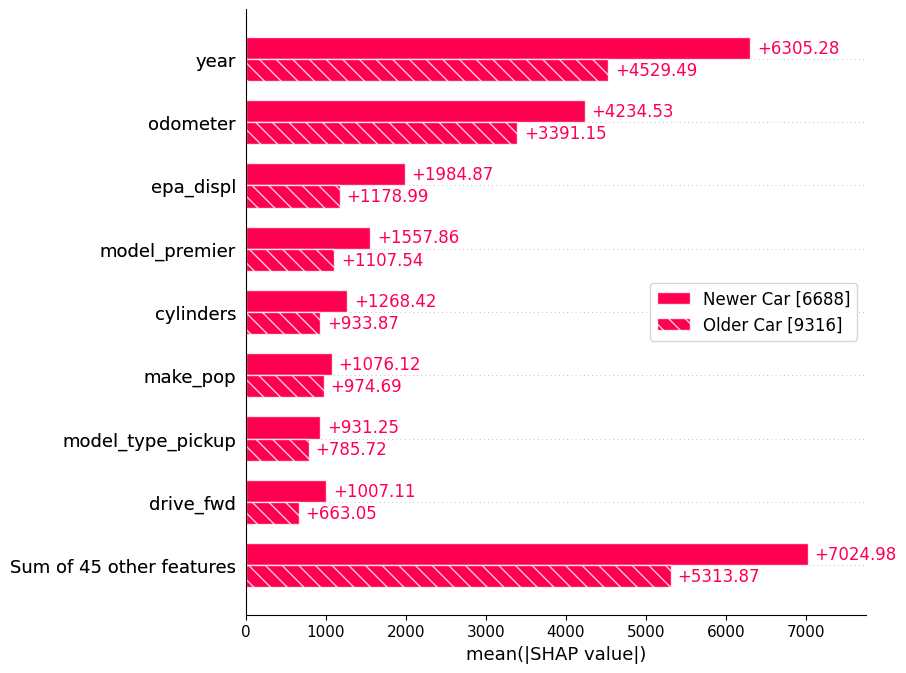

In [40]:
yr_cohort = np.where(X_reg_test.year > 2014,\
                     "Newer Car", "Older Car")

plt.figure(figsize=(12, 12), dpi=100)
shap.plots.bar(cb_reg_shap.cohorts(yr_cohort).abs.mean(0), max_display=9,\
               show=False)
plt.show()

**Beeswarm plot**

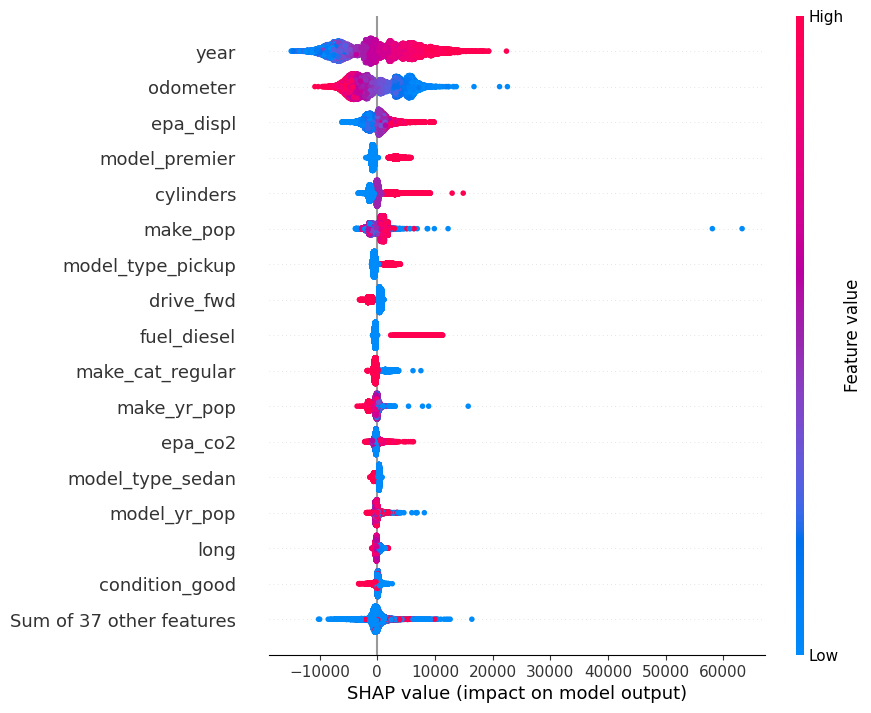

In [41]:
plt.figure(figsize=(12, 12), dpi=100)
shap.plots.beeswarm(cb_reg_shap, max_display=17, show=False)
plt.show()

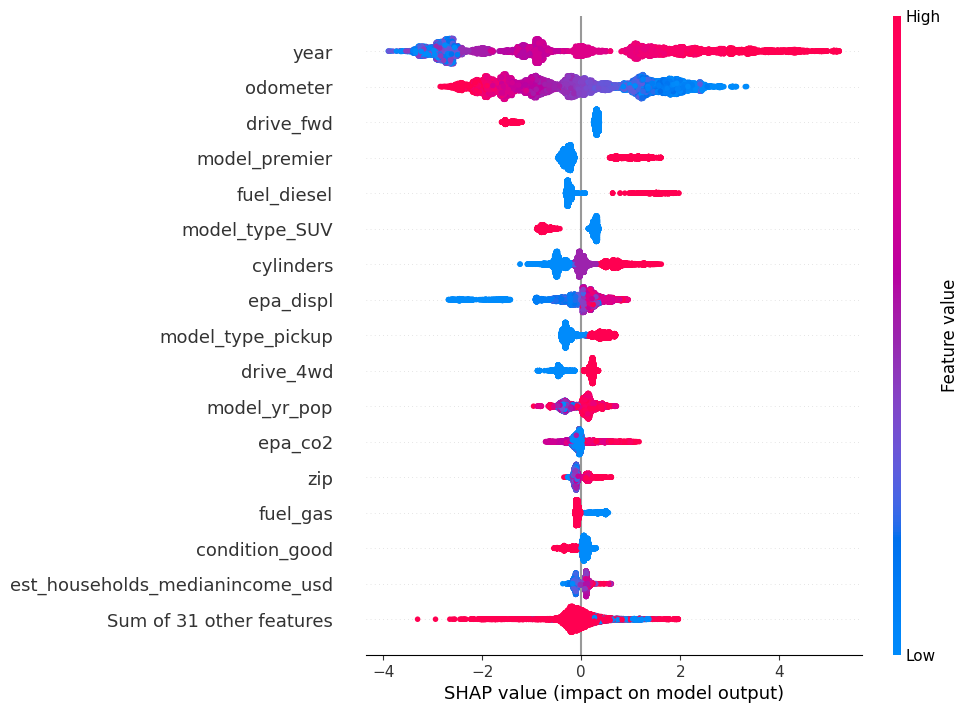

In [42]:
plt.figure(figsize=(12, 12), dpi=100)
shap.plots.beeswarm(cb_cls_shap, max_display=17, show=False)
plt.show()

#### 5.2.2) Feature Summary Explanations

**Partial dependence plots**

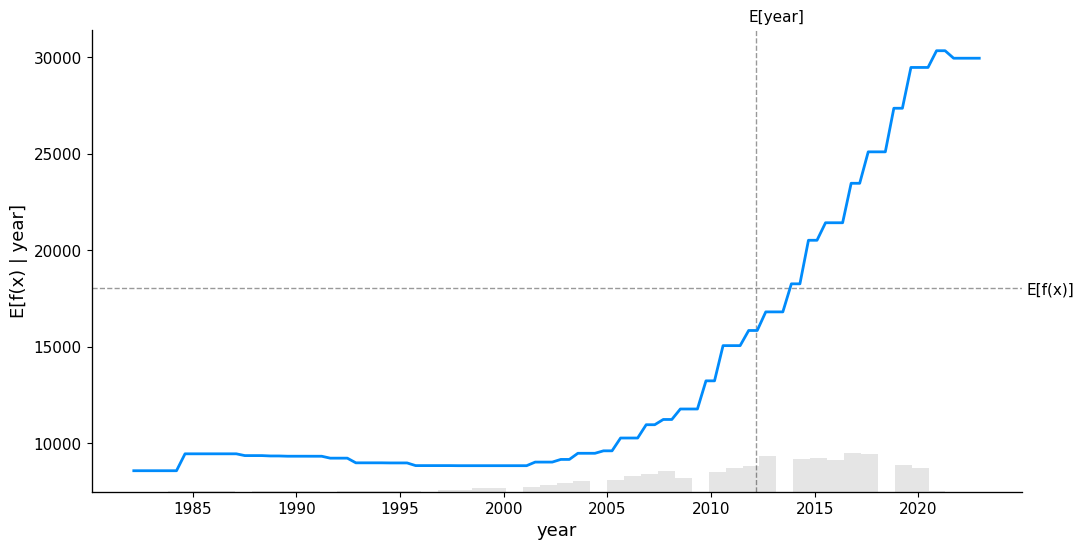

In [43]:
plt.rcParams["figure.figsize"] = (12,6)
shap.plots.partial_dependence("year", cb_reg_mdl.predict, X_reg_test,\
                              ice=False, model_expected_value=True, feature_expected_value=True,\
                              show=False)
plt.show()

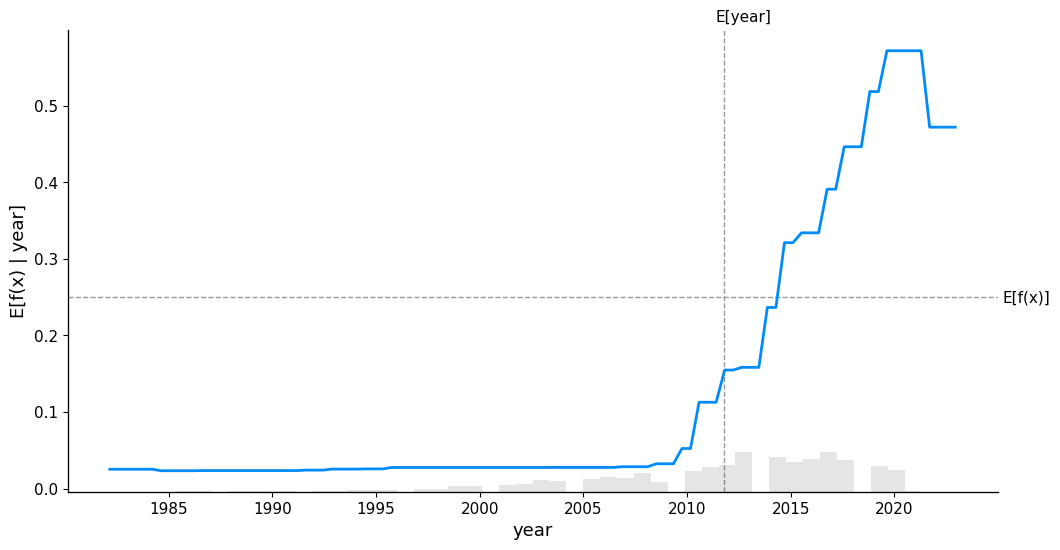

In [44]:
plt.rcParams["figure.figsize"] = (12,6)
shap.plots.partial_dependence("year", cb_cls_mdl.predict, X_cls_test,\
                              ice=False, model_expected_value=True, feature_expected_value=True,\
                              show=False)
plt.show()

In [66]:
pdp_single_feature = pdp.PDPIsolate(
    model=cb_reg_mdl, df=X_reg_test, model_features=feature_reg_l, feature='year',\
    feature_name='year', n_classes=0, n_jobs=-1
)

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

In [67]:
fig, axes = pdp_single_feature.plot(plot_pts_dist=True)
fig.show()

In [64]:
pdp_single_feature = pdp.PDPIsolate(
    model=cb_cls_mdl, df=X_cls_test, model_features=feature_cls_l, feature='year',\
    feature_name='year', n_classes=2, n_jobs=-1
)

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

In [65]:
fig, axes = pdp_single_feature.plot(plot_pts_dist=True)
fig.show()

In [69]:
fig, axes = pdp_single_feature.plot(plot_lines=True, frac_to_plot=0.01,\
                                    show_percentile=True)
fig.show()

In [70]:
pdp_single_feature = pdp.PDPIsolate(
    model=cb_reg_mdl, df=X_reg_test, model_features=feature_reg_l, feature='odometer',\
    feature_name='year', n_classes=0, n_jobs=-1
)

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

In [71]:
fig, axes = pdp_single_feature.plot(plot_lines=True, frac_to_plot=0.01)
fig.show()

In [72]:
pdp_single_feature = pdp.PDPIsolate(
    model=cb_reg_mdl, df=X_reg_test[X_reg_test.odometer < 50000], model_features=feature_reg_l, feature='odometer',\
    feature_name='year', n_classes=0, n_jobs=-1
)

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

In [73]:
fig, axes = pdp_single_feature.plot(plot_lines=True, frac_to_plot=0.05)
fig.show()

**ALE plot**

ALE plots are advantageous over PDPs because they are unbiased and faster. ALE accounts for data distributions when calculating feature effects, resulting in an unbiased representation. The algorithm divides the feature space into equally-sized windows and computes how predictions change within these windows, resulting in the _local effects_. Summing the effects across all windows makes them _accumulated_.

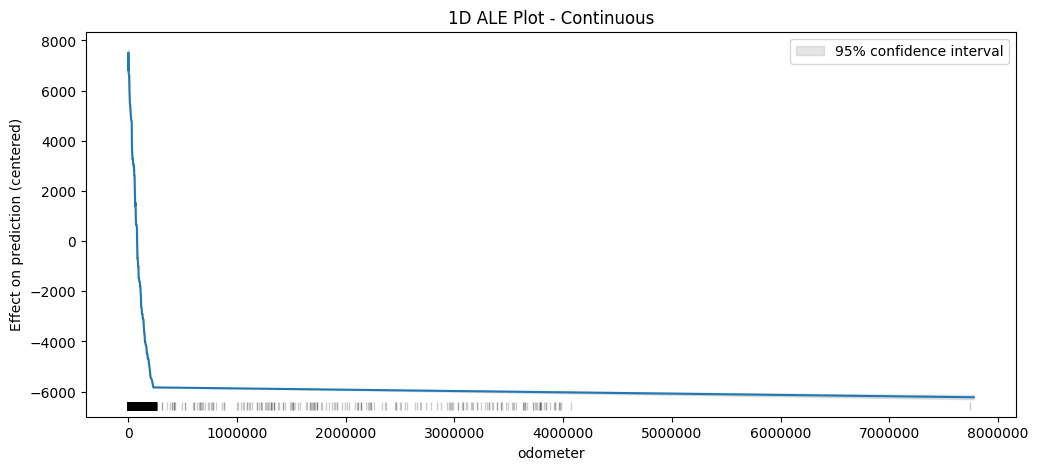

In [74]:
ale_effect = ale(X=X_reg_test, model=cb_reg_mdl, feature=['odometer'], feature_type='continuous',\
                 grid_size=80)
plt.gcf().set_size_inches(12, 5)
plt.gca().ticklabel_format(useOffset=False, style='plain')
plt.show()

It's hard to appreciate the above plot with so many outliers so let's fix that:

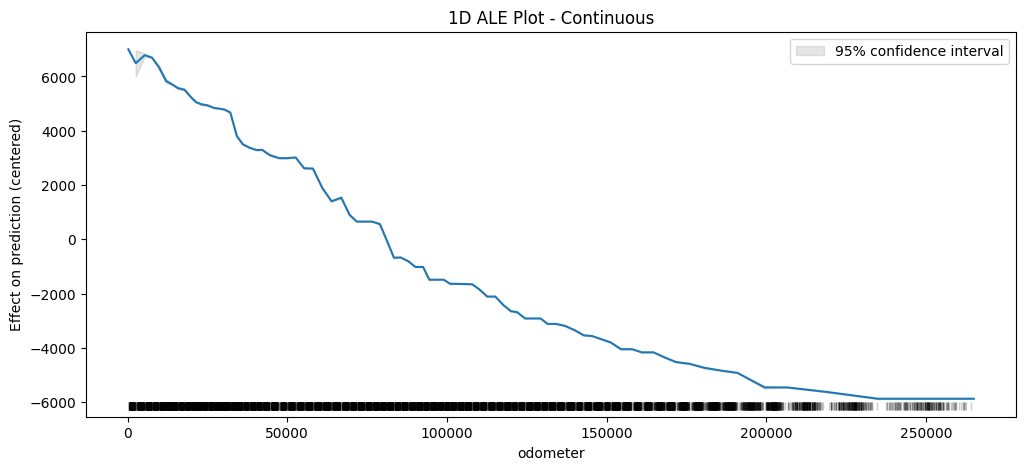

In [75]:
X_reg_test_no_outliers = X_reg_test[(X_reg_test.year.quantile(.01) <= X_reg_test.year) &\
                           (X_reg_test.year <= X_reg_test.year.quantile(.99)) &\
                           (X_reg_test.odometer.quantile(.01) <= X_reg_test.odometer) &\
                           (X_reg_test.odometer <= X_reg_test.odometer.quantile(.99))]

ale_effect = ale(X=X_reg_test_no_outliers, model=cb_reg_mdl, feature=['odometer'],\
                 feature_type='continuous', grid_size=80)
plt.gcf().set_size_inches(12, 5)
plt.gca().ticklabel_format(useOffset=False, style='plain')
plt.show()

The effect on the model goes from positive to negative as the odometer reading increases. However, unlike SHAP, in the ALE plot, it goes negative long before odometer reach 90,000. Please note the confidence interval is so thin it's only visible somewhere under 10,000. The second ALE plot shows a significant positive impact of luxury category on the outcome and that luxury vehicles are not as represented as other ones.

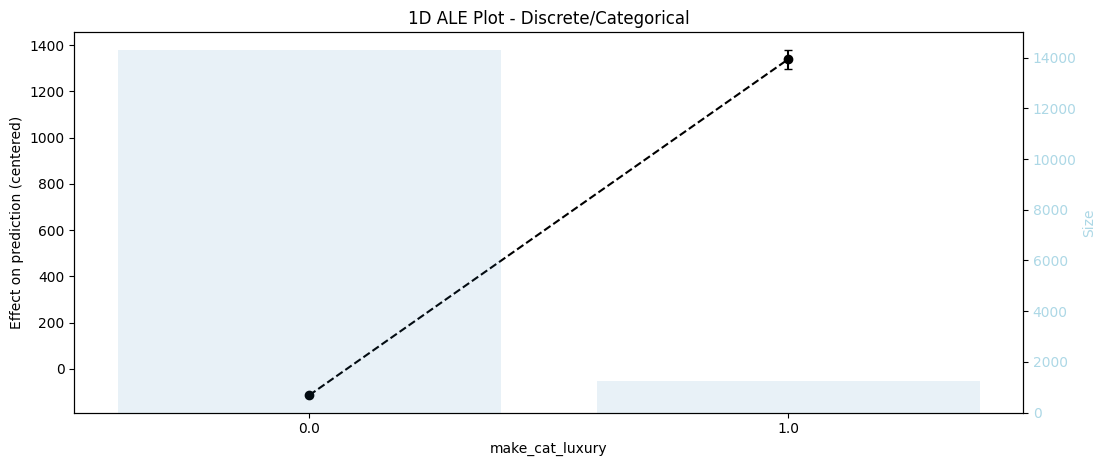

In [76]:
ale_effect = ale(X=X_reg_test_no_outliers, model=cb_reg_mdl, feature=['make_cat_luxury'],\
                 feature_type='discrete')
plt.gcf().set_size_inches(12, 5)
plt.show()

The above ALE plot shows a significant positive impact of luxury category on the outcome and that luxury vehicles are not as represented as other ones.

**SHAP scatter plot**

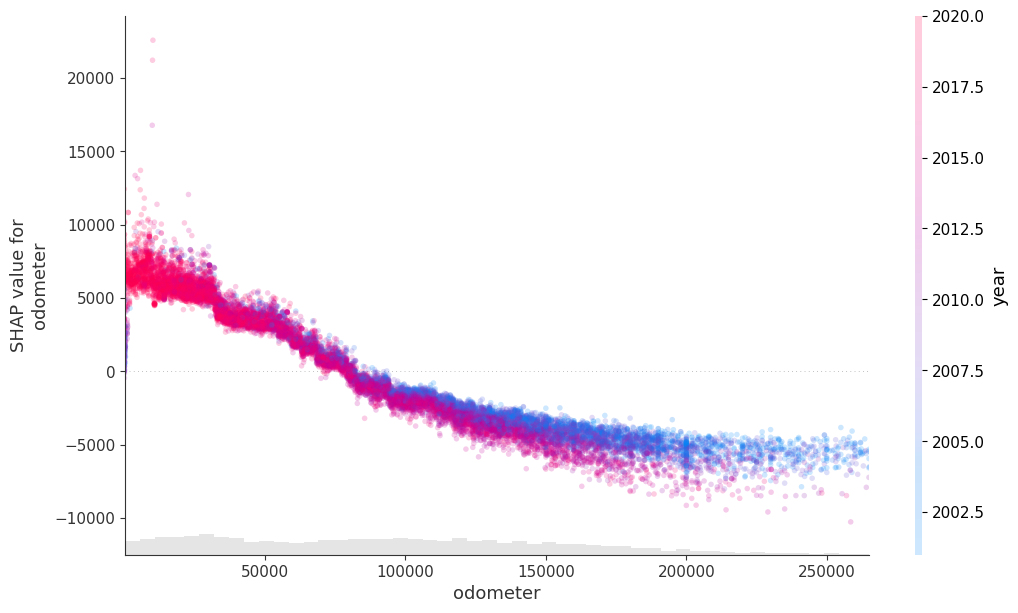

In [77]:
shap.plots.scatter(cb_reg_shap[:,"odometer"], color=cb_reg_shap[:,"year"],\
                   xmin="percentile(1)", xmax="percentile(99)", alpha=0.2,\
                   show=False)
plt.gcf().set_size_inches(12, 7)
plt.show()

This above graph depicts how a higher `odometer` reading negatively impacts the model outcome. Also, the color coding shows that the shap value for higher years is even lower when the odometer reading is over ninety thousand. In other words, a old car with a high odometer reading is expected but with a new car, it's a red flag!

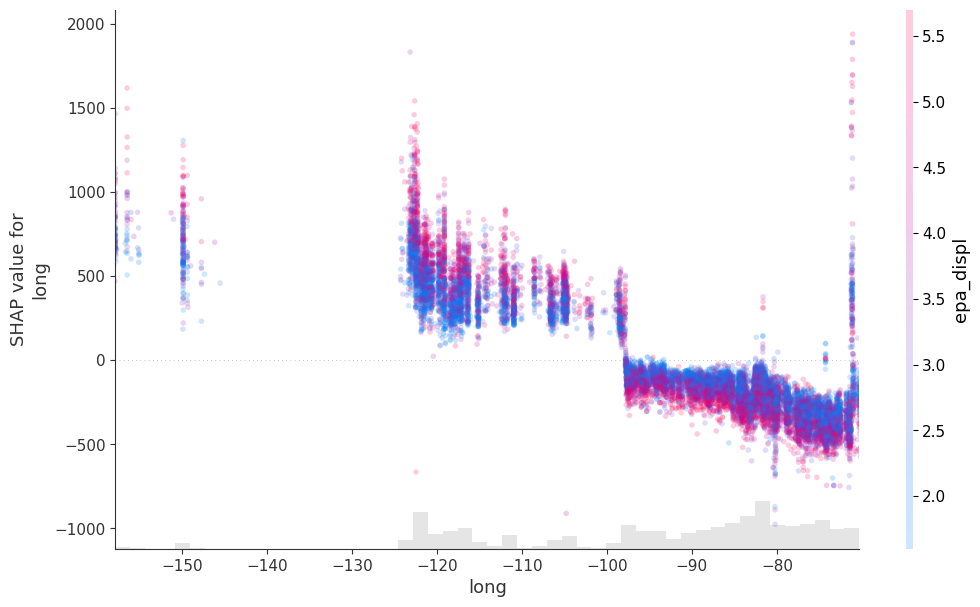

In [78]:
shap.plots.scatter(cb_reg_shap[:,"long"], color=cb_reg_shap[:,"epa_displ"],\
                   xmin="percentile(0.5)", xmax="percentile(99.5)", alpha=0.2,\
                   show=False, x_jitter=0.5)
plt.gcf().set_size_inches(12, 7)
plt.show()

This one is very interesting, it shows how the west coast of the country (at about -120°) correlates with higher shap values and the further east it goes the lower the shap values. Hawaii and Anchorage, Alaska (at about -150°) are also higher than the east coast of United States (at around -75°). The color coding shows how the more liters displaced of fuel mostly leads to higher shap values but it's not as stark of a difference the further east you go.

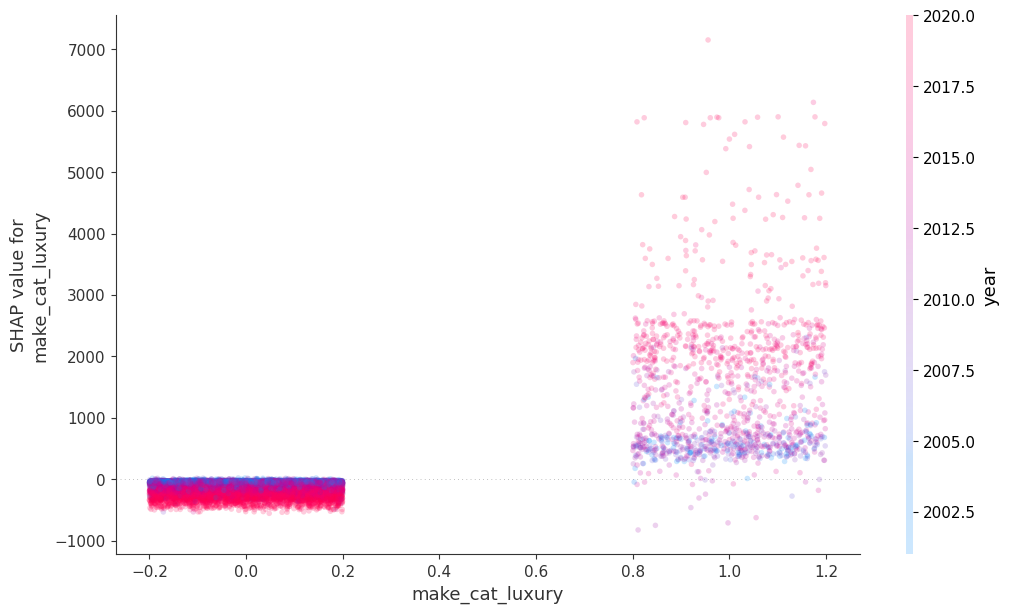

In [79]:
shap.plots.scatter(cb_reg_shap[:,"make_cat_luxury"], color=cb_reg_shap[:,"year"],\
                   x_jitter=0.4, alpha=0.2, hist=False,\
                   show=False)
plt.gcf().set_size_inches(12, 7)
plt.show()

The above plot shows that according to the SHAP values, `make_cat_luxury=1` positively impacts the model outcome, whereas `make_cat_luxury=1` has a mildly negative effect. The color coding suggests that a lower years tempers the impact making it smaller. This makes sense because older luxury cars have depreciated.

#### 5.2.3) Feature Interactions

**Clustered bar chart**

This should take 1-4 minutes

In [24]:
_, X_cls_samp, _, y_cls_samp =\
        train_test_split(X_cls, y_cls, test_size=0.2, random_state=rand)

In [27]:
%%time
clustering = shap.utils.hclust(X_cls_samp, y_cls_samp)

48it [00:56,  1.32s/it]

CPU times: user 1min 37s, sys: 697 ms, total: 1min 37s
Wall time: 58.8 s


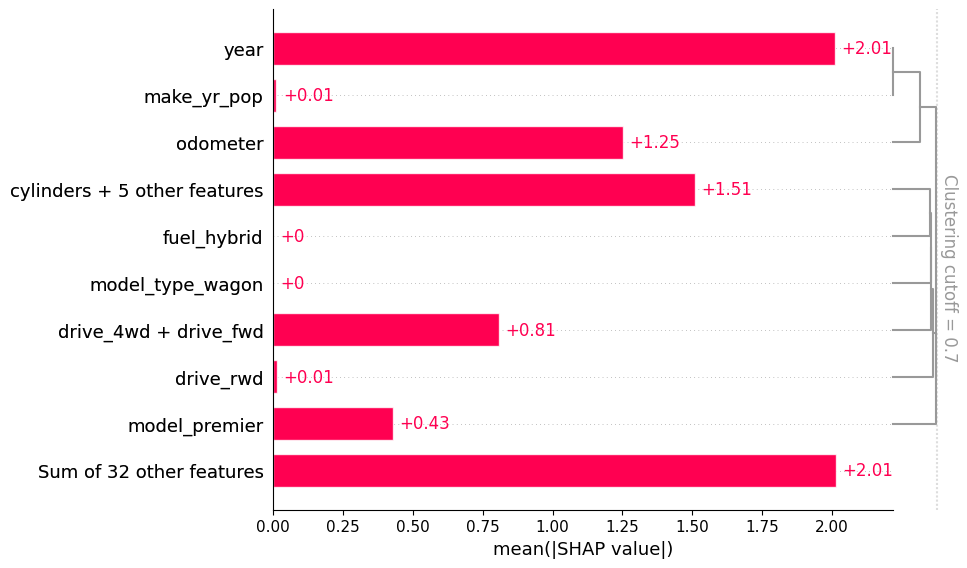

In [28]:
plt.figure(figsize=(12, 12), dpi=100)
shap.plots.bar(cb_cls_shap, clustering=clustering, clustering_cutoff=0.7,\
               show=False)
plt.show()

For instance, `year` is dependent on `make_yr_pop`, and when combined, they both depend on `odometer`, which in turn depends indirectly with a number of features including the `cylinders` feature, `model_premier` annd `fuel_other`. This finding makes sense because some categories are overall more popular than others. These insights can serve as a guide for subsequent investigations.

**ALE 2D plot**

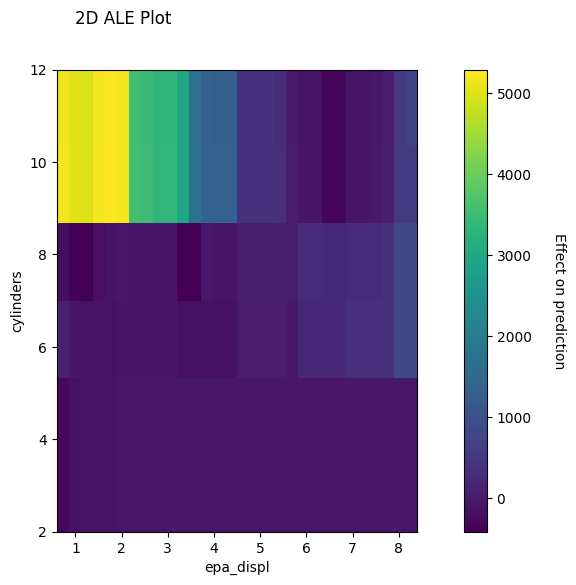

In [86]:
features_l = ["cylinders", "epa_displ"]

ale_effect = ale(X=X_reg_test, model=cb_reg_mdl, feature=features_l,\
                 feature_type='discrete', grid_size=50)
plt.show()

This distinctly illustrates higher interaction effects where `cylinders` is larger than 8 and where `epa_displ` is under 4. This finding is counterintuitive considering vehicles with a lot of cylinders are unlikely to have low amounts of engine displacement. On the other hand, the higher interaction effects when there are over 4 cylinders and an engine displacement of at least 6 literes make more sense. Please note that there are other factors su

**PDP 2D plot**

In [93]:
features_l = ["long", "lat"]

pdp_interaction_feature = pdp.PDPInteract(
    model=cb_reg_mdl, df=X_reg_test, model_features=X_reg_test.columns, features=features_l,\
    feature_names=features_l, n_classes=0, num_grid_points=15, n_jobs=-1
)

obtain pred_func from the provided model.


  0%|          | 0/15 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/15 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/225 [00:00<?, ?it/s]

In [124]:
fig, _ = pdp_interaction_feature.plot(
    plot_type='contour', plot_pdp=False)
fig.show()

It serves as proof of how the features are related to the outcome: `long` seems to be responsible for most of the effect, but in some areas `lat` seems to make a difference specially in Alaska in top left corner. We can check the reliability of this result with an actual plot. The objective is to display the distribution of the data and the predicted scores for that data, but this time it features a grid of bins that are color-coded for average score and size-coded for the number of test observations. We can contrast this with the corresponding target plot which does the same but for the labels (`target`) and not the predicted score.

In [149]:
predict_interact = info_plots.InteractPredictPlot(
                      model=cb_reg_mdl, df=X_reg_test, features=features_l, feature_names=features_l,\
                      model_features=X_reg_test.columns, n_classes=0, num_grid_points=15)

obtain pred_func from the provided model.


In [151]:
fig, _, _ = predict_interact.plot()
fig.show()

In [144]:
target_interaction = info_plots.InteractTargetPlot(\
                          df=X_reg_train.join(pd.Series(y_reg_train, index=X_reg_train.index, name='price')),\
                          target='price', features=features_l, feature_names=features_l,\
                          num_grid_points=15)

In [145]:
fig, _, _ = target_interaction.plot()
fig.show()

From the initial plot, it's evident that the median prediction are greatest on the western half (on the right side) and specially towards the southwest (on the bottom right), but not by much. And the second plot affirms that the labels are indeed more likely to be high priced in these sections of the plot. Therefore, it's no surprise that the model learned this distribution to its degree of accuracy. These plots aid in affirming a relationship between both features.

#### 5.2.4) Local Explanations

**Local Interpretable Model-agnostic explanations (LIME)**

In [29]:
cb_lime = LimeTabularExplainer(X_cls_train.values, mode="classification", class_names=class_l,\
                               feature_names=X_cls_train.columns.tolist(), kernel_width=1, verbose=True)

In [30]:
i = 6421
print("Observed:  %s" % class_l[y_cls_test[i]])
cb_lime_exp = cb_lime.explain_instance(X_cls_test.iloc[i].values, cb_cls_mdl.predict_proba)
cb_lime_exp.show_in_notebook()

Observed:  Low Price
Intercept 0.33441328405352827
Prediction_local [0.15947655]
Right: 0.001656478876585787


In [31]:
i = 2004
print("Observed:  %s" % class_l[y_cls_test[i]])
cb_lime_exp = cb_lime.explain_instance(X_cls_test.iloc[i].values, cb_cls_mdl.predict_proba)
cb_lime_exp.show_in_notebook()

Observed:  High Price
Intercept 0.01987615518645819
Prediction_local [0.57349464]
Right: 0.9784993446701948


**SHAP Bar plot**

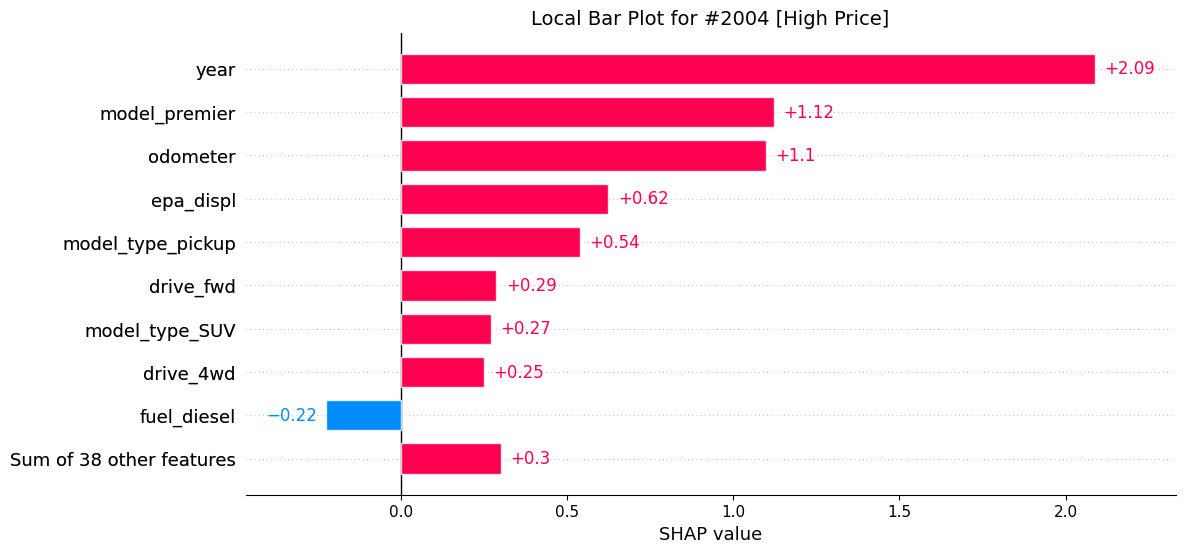

In [32]:
shap.plots.bar(cb_cls_shap[2004], show=False)
plt.gcf().set_size_inches(12, 6)
plt.title('Local Bar Plot for #2004 [High Price]', fontsize=14)
plt.show()

**SHAP waterfall plot**

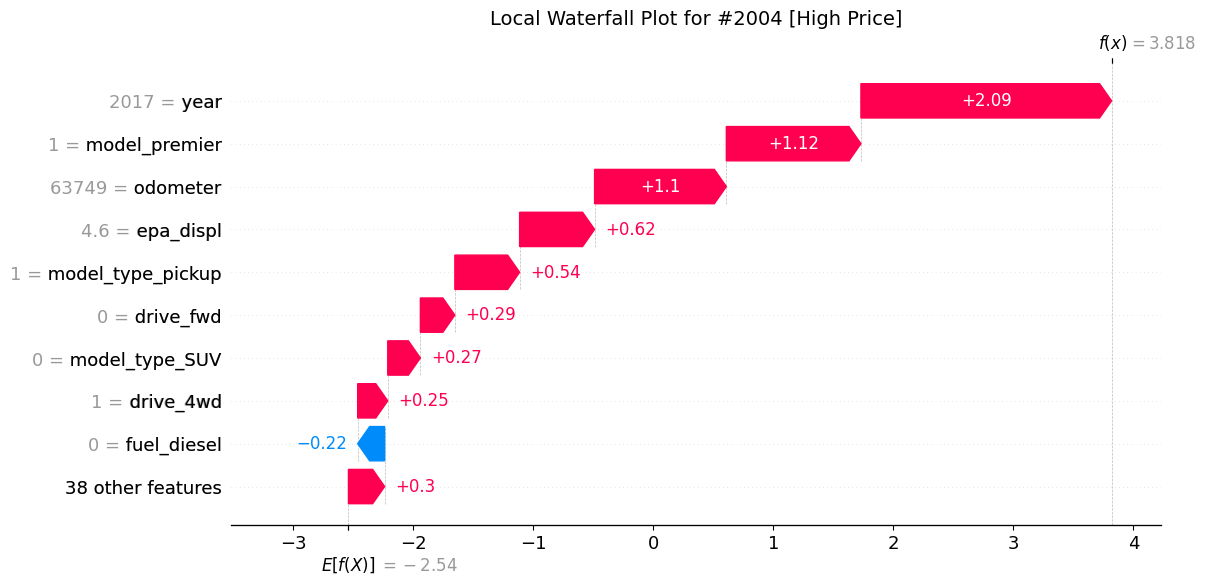

In [33]:
shap.plots.waterfall(cb_cls_shap[2004], show=False)
plt.gcf().set_size_inches(12, 6)
plt.title('Local Waterfall Plot for #2004 [High Price]', fontsize=14)
plt.show()

**SHAP force plot**

In [34]:
shap.initjs()
shap.plots.force(cb_cls_shap[2004]) #, matplotlib=True

**SHAP decision plots**

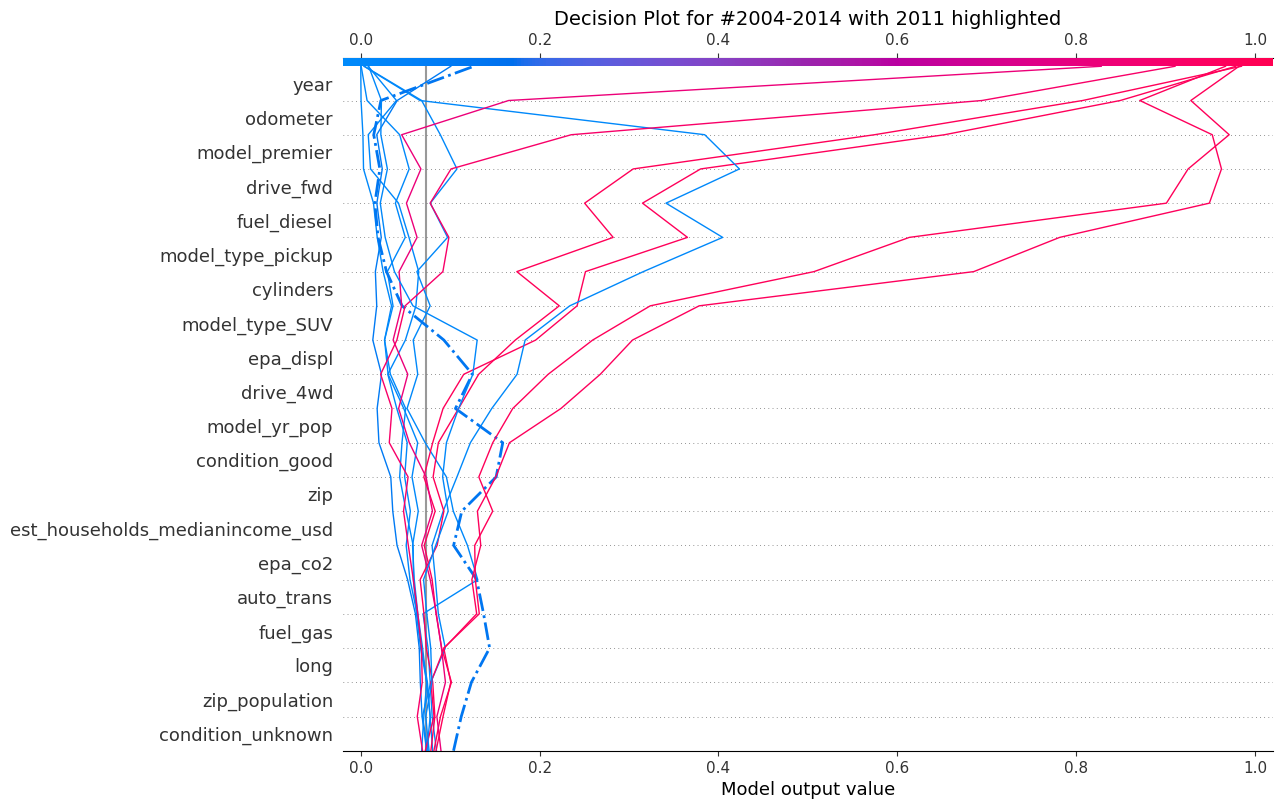

In [35]:
shap.decision_plot(cb_cls_explainer.expected_value, cb_cls_shap.values[2000:2014], X_cls_test.iloc[16:2014], highlight=7,\
                   show=False, link='logit')
plt.gcf().set_size_inches(12, 9)
plt.title('Decision Plot for #2004-2014 with 2011 highlighted', fontsize=14)
plt.show()

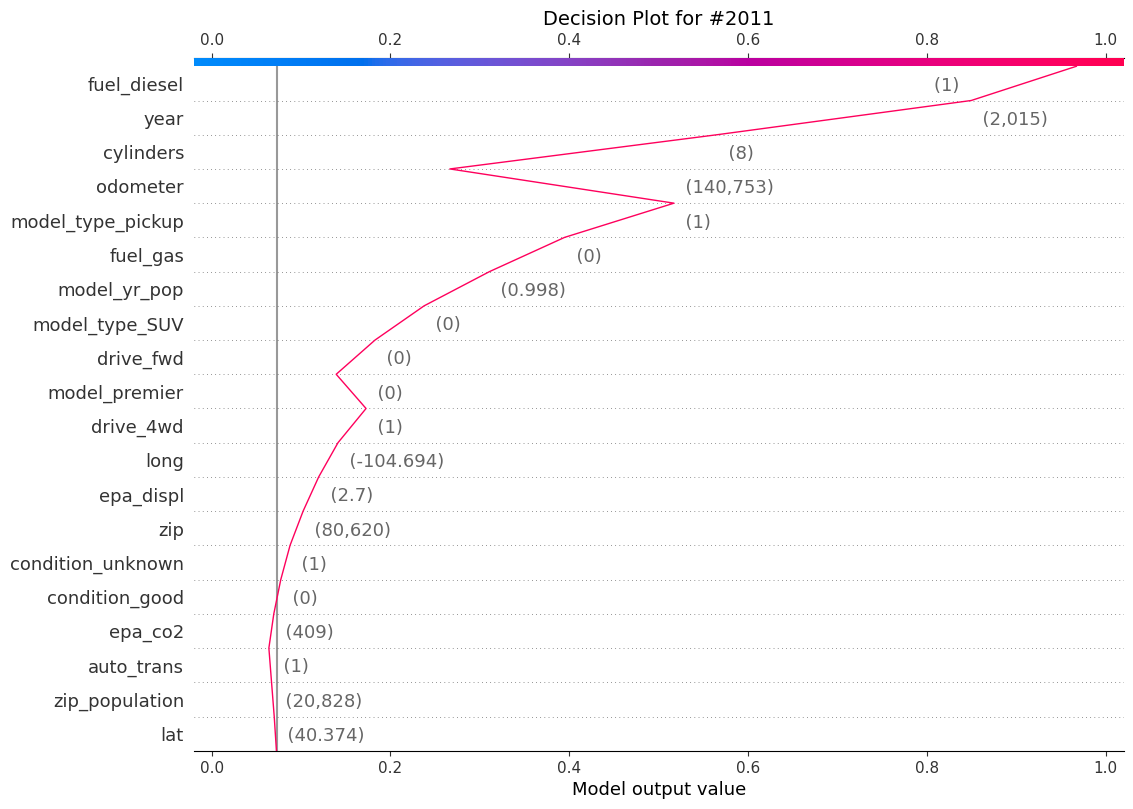

In [36]:
shap.decision_plot(cb_cls_explainer.expected_value, cb_cls_shap.values[2011], X_cls_test.iloc[2011],\
                   show=False, link='logit')
plt.gcf().set_size_inches(12, 9)
plt.title('Decision Plot for #2011', fontsize=14)
plt.show()